In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
value="Click here to toggle on/off the raw code."></form>''')

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
import re
import time
import os.path
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from IPython.display import Image
from IPython.core.display import HTML

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from sqlalchemy import create_engine
from sqlalchemy.engine.reflection import Inspector
engine = create_engine('sqlite:///main_df.db')

plt.rcParams["figure.figsize"] = (6, 6)

In [4]:
# PCA functions

def pca(X):
    """
    Perform Principal Component Analysis
    
    """
    X_bar = np.mean(X, axis=0)
    X = X - X_bar
    
    cov = np.dot(X.T, X) # covariance
    eig_vals, eig_vecs = np.linalg.eig(cov)
    
    index = eig_vals.argsort()[::-1]
    eig_vals = eig_vals[index]
    eig_vecs = eig_vecs[:,index]
    
    X_new = np.matmul(X, eig_vecs)
    w = eig_vecs
    variance_explained = eig_vals / eig_vals.sum()
    
    return X_new, w, variance_explained

def plot_pca(X_new, features, w, pc_total):
    """
    Plot transformed data and features on to all vectors
    
    """
    for i in range(pc_total-1):
        fig, ax = plt.subplots(1, 2, subplot_kw=dict(aspect='equal'),
                               gridspec_kw=dict(wspace=0.4), dpi=150)
        
        ax[0].scatter(X_new[:,i], X_new[:,i+1], marker='.', s=3, 
                      c='rebeccapurple')
        ax[0].set_xlabel('PC' + str(i+1), fontsize=10)
        ax[0].set_ylabel('PC' + str(i+2), fontsize=10)
        ax[0].set_xlim(-1.5, 1.5)
        ax[0].set_ylim(-1.5, 1.5)
        
        for spine in ['top', 'right']:
            ax[0].spines[spine].set_visible(False)
            
        for feature, vec in zip(features, w):
            ax[1].arrow(0, 0, 2.5*vec[i], 2.5*vec[i+1], width=0.01, 
                        ec='none', fc='forestgreen')
            ax[1].text(3*vec[i], 3*vec[i+1], feature, ha='center', 
                       color='rebeccapurple', fontsize=5, weight='bold')
                
        #ax[1].set_xlim(-1, 1)
        #ax[1].set_ylim(-1, 1)
        ax[1].set_xlabel('PC' + str(i+1))
        ax[1].set_ylabel('PC' + str(i+2))
        ax[1].tick_params(axis='both',which='both',top=False, bottom=False,
                          labelbottom=False, labelleft=False, left=False)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax[1].spines[spine].set_visible(False)

In [5]:
# ML models

def train_knn(X, y):
    """
    kNN Regressor function
    
    """
    start_time = time.time()
    score_train = []
    score_val = []
  
    test_len = int(len(y)*0.2)
  
    X_test = X[-test_len:]
    y_test = y[-test_len:]
  
    X_train_val = X[:-test_len]
    y_train_val = y[:-test_len]
  
    for seed in range(1, Number_trials+1):
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                          y_train_val, 
                                                          test_size=0.25, 
                                                          random_state=seed)
        neighbors_settings = range(1,15)
        acc_train = []
        acc_val = []
  
        for n_neighbors in neighbors_settings:   
            reg = KNeighborsRegressor(n_neighbors=n_neighbors)
            reg.fit(X_train, y_train)    
            acc_train.append(reg.score(X_train, y_train))
            acc_val.append(reg.score(X_val, y_val))
  
        score_train.append(acc_train)
        score_val.append(acc_val)   
      
    score_train_mean = np.mean(score_train, axis=0)
    score_val_mean = np.mean(score_val, axis=0)
    max_id = np.argmax(score_val_mean)
    best_knn = KNeighborsRegressor(n_neighbors=max_id+1).fit(X_train, y_train)
    score_test = best_knn.score(X_test, y_test)
  
    run_time = (time.time() - start_time)
    return ['kNN', score_train_mean[max_id], np.amax(score_val_mean), 
            score_test, 'N_Neighbor = {0}'.format(max_id+1), 'NA', run_time]

def train_ridge(X, y):
    """
    Ridge Regressor function
    
    """
    start_time = time.time()
    all_training_r = pd.DataFrame()
    all_val_r = pd.DataFrame()
  
    test_len = int(len(y)*0.2)
  
    X_test = X[-test_len:]
    y_test = y[-test_len:]
  
    X_train_val = X[:-test_len]
    y_train_val = y[:-test_len]
  
    for seedN in range(1, Number_trials+1):
        X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                          y_train_val,
                                                          test_size=0.25,
                                                          random_state=seedN)
        training_accuracy = []  
        val_accuracy = []
        alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2,
                          0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10]
      
        for alpha_run in alpha_parameter:   
            ridge = Ridge(alpha=alpha_run, max_iter=1000000)
            ridge.fit(X_train, y_train) #build the model 
            training_accuracy.append(ridge.score(X_train, y_train))
            val_accuracy.append(ridge.score(X_val, y_val))  
        all_training_r[seedN] = training_accuracy
        all_val_r[seedN] = val_accuracy
  
    max_id_r = all_val_r.mean(axis=1).idxmax()
    max_mean_val_r = all_val_r.mean(axis=1).max()
    max_alpha_r = alpha_parameter[max_id_r]
    max_mean_tr_r = all_training_r.mean(axis=1)[max_id_r]
  
    ridge_best = Ridge(alpha=max_alpha_r, max_iter=1000000).fit(X_train, 
                                                                y_train)
    max_test_r = ridge_best.score(X_test, y_test)
    top_pred = column_names[np.argmax(np.abs(ridge_best.coef_))]
  
    run_time = (time.time() - start_time)
  
    abs_mean_coefs = np.abs(ridge_best.coef_)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs), 
            color="rebeccapurple")
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(column_names[np.argsort(abs_mean_coefs)])
    ax.set_title('Ridge')
    return ['Ridge', max_mean_tr_r, max_mean_val_r, max_test_r, 
            'Alpha = {0}'.format(max_alpha_r), top_pred, run_time]

def train_lasso(X, y):
    """
    Lasso Regressor function
    
    """
    start_time = time.time()
    all_training_l = pd.DataFrame()
    all_val_l = pd.DataFrame()
  
    test_len = int(len(y)*0.2)
  
    X_test = X[-test_len:]
    y_test = y[-test_len:]
  
    X_train_val = X[:-test_len]
    y_train_val = y[:-test_len]
  
    for seedN in range(1, Number_trials+1):
        X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                          y_train_val,
                                                          test_size=0.25,
                                                          random_state=seedN)
        training_accuracy = []  
        val_accuracy = []
        alpha_parameter = [1e-5, 1e-4, 1e-3, 7e-3, 1e-2, 5e-2,
                          0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 10]
      
        for alpha_run in alpha_parameter:   
            lasso = Lasso(alpha=alpha_run, max_iter=1000000)
            lasso.fit(X_train, y_train)
            training_accuracy.append(lasso.score(X_train, y_train))
            val_accuracy.append(lasso.score(X_val, y_val))
        all_training_l[seedN] = training_accuracy
        all_val_l[seedN] = val_accuracy
  
    max_id_l = all_val_l.mean(axis=1).idxmax()
    max_mean_val_l = all_val_l.mean(axis=1).max()
    max_alpha_l = alpha_parameter[max_id_l]
    max_mean_tr_l = all_training_l.mean(axis=1)[max_id_l]
  
    lasso_best = Lasso(alpha=max_alpha_l, max_iter=100000000).fit(X_train, 
                                                                  y_train)
    max_test_l = lasso_best.score(X_test, y_test) 
    top_pred = column_names[np.argmax(np.abs(lasso_best.coef_))]
  
    run_time = (time.time() - start_time)
  
    abs_mean_coefs = np.abs(lasso_best.coef_)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs), 
            color="rebeccapurple")
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(column_names[np.argsort(abs_mean_coefs)])
    ax.set_title('Lasso')
  
    return ['Lasso', max_mean_tr_l, max_mean_val_l, max_test_l, 
            'Alpha = {0}'.format(max_alpha_l), top_pred, run_time]

def train_linreg(X, y):
    """
    Linear Regressor function
    
    """
    start_time = time.time()
    training_accuracy = []
    val_accuracy = []
    test_accuracy = []
  
    test_len = int(len(y)*0.2)
  
    X_test = X[-test_len:]
    y_test = y[-test_len:]
  
    X_train_val = X[:-test_len]
    y_train_val = y[:-test_len]
  
    for seedN in range(1, Number_trials+1):
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, 
                                                          y_train_val, 
                                                          test_size=0.25, 
                                                          random_state=seedN)
        lr = LinearRegression().fit(X_train, y_train)
  
        training_accuracy.append(lr.score(X_train, y_train))
        val_accuracy.append(lr.score(X_val, y_val))
        test_accuracy.append(lr.score(X_test, y_test))
  
    lr_best = LinearRegression().fit(X_train, y_train)
    top_pred = column_names[np.argmax((np.abs(lr_best.coef_)))]
  
    run_time = (time.time() - start_time)
  
    abs_mean_coefs = np.abs(lr_best.coef_)
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(5,10))
    
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs), 
            color="rebeccapurple")
        
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(column_names[np.argsort(abs_mean_coefs)])
    ax.set_title('Linear Regression')
  
    return ['Linear Regression', np.mean(training_accuracy), 
            np.mean(val_accuracy), np.mean(test_accuracy), 'NA', 
            top_pred, run_time]


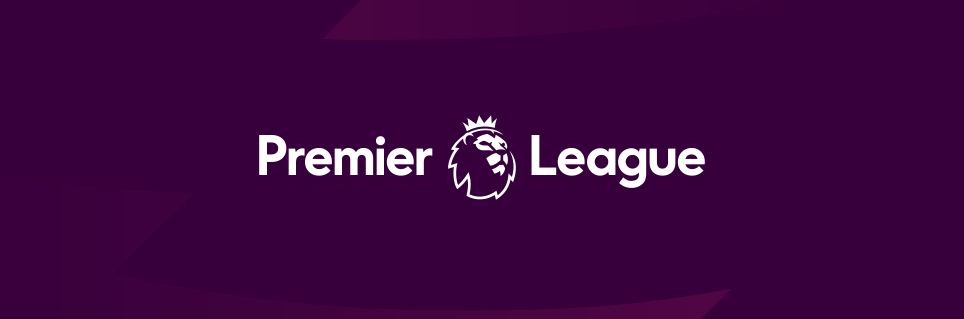

In [6]:
Image(filename="prem.png")

# Boom or Bust? Determining Football Fantasy League Performance Based On On-field Player Statistics

## Executive Summary
<br>

<div style="text-align: justify"> Football is arguably the most famous sport with a global following of approximately 3.5 to 4 billion fans, and has the highest television audience in sports worldwide. Some of the most well-known athletes to ever play the game are Lionel Messi and Cristiano Ronaldo, huge household namesin Football. They are fan-favorites not because they play the game but also because they play it really well. Sports, including football, has now evolved to more than being an entertainment spectacle. Fans and enthusiasts are immersed into all facets of the game, including intricate game details and player statistics. This is where the game of Fantasy Sports comes in. Individuals compete based on the actual performance of players in sports. Player performance is determined by individual statistics which are converted to points then tallied by season-end. Websites such as the English Premier League website and FBREF.com contain rich data on football player statistics and Fantasy football. </div><br>
    
<div style="text-align: justify">In this project, our group analyzed various player and game statistics from FBREF.com and the English Premier League website. Data was extracted using manual webscraping and an API. The group stored the data in a database and matched player data from FBREF.com and the EPL website to come up with a main table containing player stats and their equivalent year-end Fantasy football points. We used Principal Component Analysis to determine the correlation between features  and how they relate to fantasy points. Results show that attacker or offense-related statistics and goalkeeper statistics contribute the most in determining footballer players' total fantasy points. This is seen in our visualization of the top players segregated by statistics, our PCA analysis, and several machine learning models featured in this report. The findings in this report can be used by football fans and sports fans in general who are into Football and Fantasy Sports. </div><br>
  
<div style="text-align: justify">This paper features data that spans only players and statistics in the 2020-2021 season of the English Premier League. We recommend future researchers to expand the scope of player statistics and go beyond the last football season. We also suggest to delve into more comprehensive techniques such as other machine learning models so as to cover more ground in their analyses and investigation.  Finally, we recommend possibly exploring other websites and other football leagues for better comparison and conclusions.</div>

## Table of Contents

* Executive Summary
* Introduction
* Problem Statement
* Data Description 
* Methodology
   - Data Extraction and Storage
   - Data Cleaning and Merging
   - Exploratory Data Analysis
   - Dimensionality Reduction
   - Machine Learning
* Results
   - Exploratory Data Analysis
   - Dimensionality Reduction
   - Machine Learning 
* Conclusion and Recommendation 
* References

## 1. Introduction

### Premier League
<br>

<div style='text-align: justify;'>The Premier League, often referred to as the English Premier League or the EPL is the top level of the English football league system. It is contested by twenty football clubs and operates on a system of promotion and relegation with the English Football League (EFL). Seasons run from August to May with each team playing 38 matches (playing all 19 other teams both home and away). Most games are played on Saturday and Sunday afternoons. The competition was founded as the FA Premier League on February 20, 1992 following the decision of clubs in the Football League First Division to break away from the Football League and take advantage of a lucrative television rights sale. The Premier League is a corporation where chief executive Richard Masters is responsible for its management and the member clubs act as shareholders. Clubs were portioned central payment revenues of £2.4 billion in 2016–17, with a further £343 million in solidarity payments to English Football League (EFL) clubs. </div> <br>
    
<div style='text-align: justify;'>The Premier League is the most-watched sports league in the world, broadcasted in 212 territories to 643 million homes and a potential TV audience of 4.7 billion people. For the 2018–2019 season the average Premier League match attendance was at 38,181 while the aggregated attendance across all matches was the highest of any league at 14,508,981. Most stadium occupancies are always at near capacity.  The English top-flight has produced the second-highest number of UEFA Champions League/European Cup titles, with five English clubs having won fourteen European trophies in total. </div> <br>
    
<div style='text-align: justify;'>Fifty clubs have competed since the inception of the Premier League in 1992. </div> 

Seven of them have won the title:

- Manchester United<b>(13)</b>
- Chelsea <b>(5)</b>,
- Manchester City <b>(5)</b>
- Arsenal <b>(3) </b>
- Blackburn Rovers <b>(1)</b>
- Leicester City <b>(1)</b>
- Liverpool <b>(1)</b>

### FBREF.COM
<br>
<div style='text-align: justify;'>FBref.com is a website devoted to tracking statistics for football teams and players from around the world. FBref was created by Sports-Reference, the team behind popular statistics websites like <b>Baseball-Reference</b> and <b>Basketball-Reference</b>. Sister websites feature American football, hockey, and college sports.</div>

### Fantasy Sports
<br>
<div style='text-align: justify;'>A fantasy sport is a type of game, often played using the Internet, where participants assemble imaginary or virtual teams composed of proxies of real players of a professional sport. These teams compete based on the statistical performance of those players in actual games. This performance is converted into points that are compiled and totaled according to a roster selected by each fantasy team's manager. These point systems can be simple enough to be manually calculated by a "league commissioner" who coordinates and manages the overall league, or points can be compiled and calculated using computers tracking actual results of the professional sport. In fantasy sports, team owners draft, trade and cut (drop) players, similar to real sports.</div><br>

<div style='text-align: justify;'>Points for Fantasy Football are gained or deducted depending on players' performances.<br><br>
Points are typically awarded for some or all of the following achievements:</div>

- Playing in a match (or part of a match e.g. at least 60 minutes)
- Scoring a goal
- Earning an assist (the pass or touch leading to the goal)
- Keeping a clean sheet (goalkeepers, midfielders, and defenders only)
- Saving a penalty (goalkeeper only)
- Goalkeeper saves three shots or more
- Win for the player's team<br>

Points can also be deducted for some or all of the following:

- Conceding a goal (goalkeepers and defenders only)
- Receiving a yellow or red card
- Missing a penalty kick
- Scoring an own goal
- Getting substituted
- Loss for the player's team






## 2. Problem Statement

<br>

<div style='text-align: justify;'>This technical report aims to provide Fantasy Football fans and football enthusiasts in general with a  descriptive and analytical overview of the English Premier League, football players, and how they all fare in the game of Fantasy Football. It also seeks to provide additional and pertinent insights on league statistics, individual player statistics, and Fantasy Football scores. Stakeholders and curious fans are able to use this report to draw analyses on the performance of their favorite football teams as well as players. The proponents have only included players that played in the 2020-2021 season of the English Premier League.</div>


## 3. Data Description
<br>


<div style='text-align: justify;'> All extracted data was saved in the <b>main_df</b> database file. Nine tables were created for the data from the <b>fbref</b> website. Each table corresponds to a particular category of player statistics. These nine tables were later merged to the <b>complete</b> table. Meanwhile, data from the <b>Fantasy Premier League</b> website was saved in the table <b>fantasy_stats</b>. The two final tables were finally merged to create the main table used for this project which was named as the <b>overlap</b> table. </div>

<br>
<center style="font-size:12px;font-style:default;"><b>Table 3.1 main_df Database</b></center>



| Table Name | Description | Rows | Columns |
| :- | :- | :-: | :-: |
| main_stats | Contains cleaned and organized scraped data from FBRef's Standard Player Stats | 524 | 12 |
| keepers | Contains cleaned and organized scraped data from FBRef's Standard Goal Keeper Stats | 41 | 4 |
| shooting | Contains cleaned and organized scraped data from FBRef's Standard Shooting Stats | 524 | 5 |
| passing_type | Contains cleaned and organized scraped data from FBRef's Standard Passing Stats | 524 | 5 |
| gca | Contains cleaned and organized scraped data from FBRef's Standard Goal Creation Stats | 524 | 3 |
| defense | Contains cleaned and organized scraped data from FBRef's Standard Defensive Stats | 524 | 6 |
| possession | Contains cleaned and organized scraped data from FBRef's Standard Possession Stats | 524 | 5 |
| misc | Contains cleaned and organized scraped data from FBRef's Standard Miscellaneous Stats | 524 | 6 |
| complete | Contains merged scraped data from all FBRef's Stats Combined | 524 | 38 |
| fantasy_stats | Contains cleaned and organized scraped data from Fantasy PL's Total Fantasy Points | 566 | 4 |
| overlap | Main Table - contains merged scraped data from FBRef and Fantasy PL sites | 351 | 39 |


<br>

 <div style='text-align: justify;'> The <b>overlap</b> table contains scraped data from both sites. It is the overlap of the two tables in terms of matching players. Below are the selected features found in the table: </div>

<br>

<center style="font-size:12px;font-style:default;"><b>Table 3.2 Overlap Table Feature Name, Type and Description</b></center>



| Feature | Data Type | Description |
| :- | :- | :- |
| player | str | Player Name |
| nation | str | Nationality |
| pos | str | Playing Position |
| squad | str | Team |
| age | int64 | Age |
| starts | int64 | Games Started |
| min | int | Minutes Played |
| gls | int64 | Total Goals |
| ast | int64 | Total Assists |
| crdr | int64 | Total Red Cards |
| crdy | int64 | Total Yellow Cards |
| ck | int64 | Total Corner Kicks |
| cmp | int64 | Total Completed Passes |
| crs | int64 | Total  Crosses|
| ti | int64 | Total Throw Ins Taken |
| gca | int64 | Total Goal Creating Actions |
| sca | int64 | Total Shot Creating Actions |
| clr | int64 | Total Clearances |
| int | int64 | Total Interceptions |
| tkl | int64 | Total Tackles |
| blocks | int64 | Total Blocks |
| press | int64 | Total Defensive Presses |
| fk | int64 | Total Free Kicks |
| pk | int64 | Total Penalty Kicks |
| sh | int64 | Total Shots |
| sot | int64 | Total Shots on Target |
| carries | int64 | Total Ball Carries |
| rec | int64 | Total Passes Received |
| succ | int64 | Total Successful Dribbles |
| touches | int64 | Total Ball Touches |
| fls | int64 | Total Fouls |
| off | int64 | Total Offsides |
| og | int64 | Total Own Goals |
| recov | int64 | Total Recovered Loose Balls |
| won | int64 | Total Aerial Won |
| cs | int64 | Total Clean Sheets |
| pksv | int64 | Total Penalty Kick Saves |
| saves | int64 | Total Shot on Target Saves |
| total_points | int64 | Total Fantasy Points |

<br>

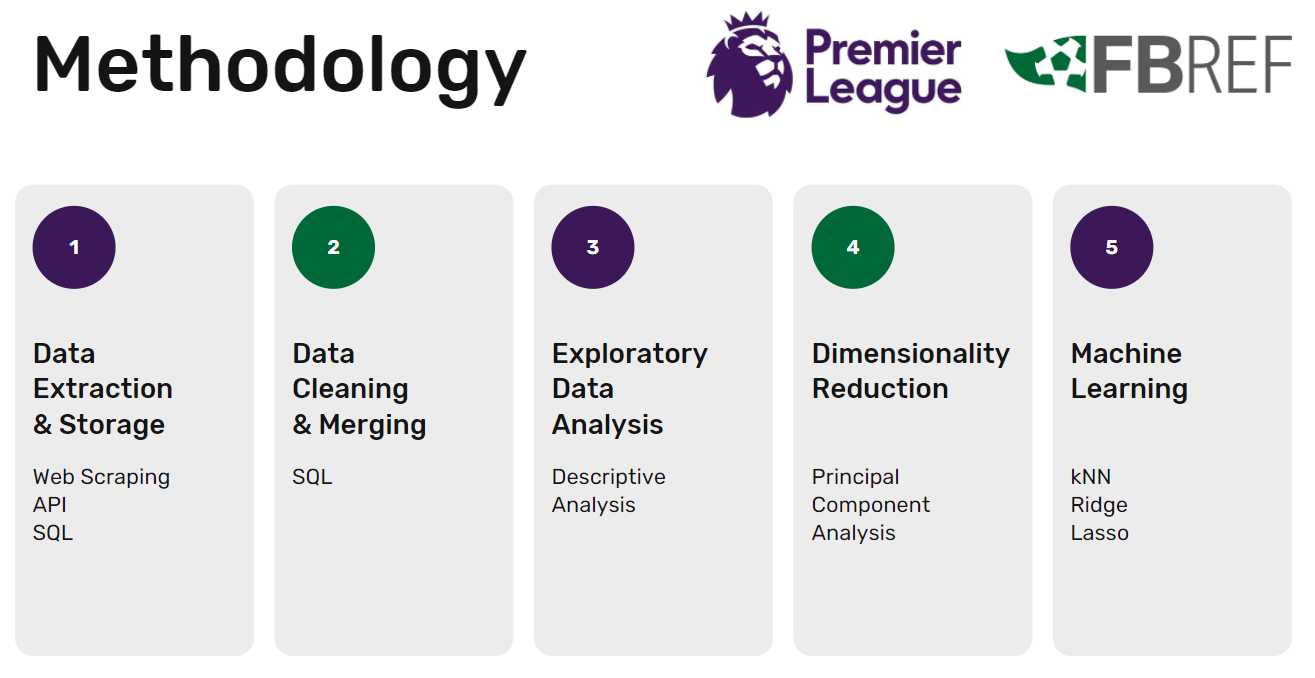

In [7]:
Image(filename="method.PNG")

## 4. Methodology

### 4.1 Data Extraction and Storage
<br>

<div style='text-align: justify;'>Data was extracted from two websites, particularly, <b>fbref.com</b> and <b>fantasy.premierleague.com</b>. FBRef had to be scraped manually meanwhile the Fantasy Premier League website had an available API. Data from these sites were merged after data collection and cleaning. </div>


### 4.1.1 FBREF Data (Web Scrape)
<br>

<div style='text-align: justify;'>Fbref.com was used to get player statistics data from the <b>Premier League’s 2020-2021 season</b> (last season). The endpoint used was <b>https://fbref.com/en/comps/9/10728/table_name/2020-2021-Premier-League-Stats</b>. The website had several tables separated per players statistics category. The <b>table_name</b> in the endpoint pertains to the specific URL name of each table.</div><br>

<div style='text-align: justify;'>Specific data was extracted from a total of 9 tables <b>(Table 3.1)</b> and each was saved into a separate table in the main database <b>main_df.db</b>. The player column which corresponds to the player’s name was used as the primary key of each table to uniquely identify every entry. Please see  code below for the data extraction and storage of data from the FBRef website.</div>

``` python
engine = create_engine('sqlite:///main_df.db')

# URL list for request loop
url_list = ['stats', 'keepers', 'shooting', 'passing_types', 'gca', 
            'defense', 'possession', 'misc']

for table in url_list:
    url = ('https://fbref.com/en/comps/9/10728/' + table + 
           '/2020-2021-Premier-League-Stats')
    res = requests.get(url)
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    
    soup_a = soup.find_all('thead')
    soup_b = soup_a[2].find_all('tr')[1] #for column names
    soup_c = soup.find_all('tbody')[2] #for data
    
    #create column headers 
    column_list = []
    for element in soup_b:
        if element.string != '\n':
            if element.string.lower() in column_list:
                column_list.append(element.string.lower() + '_2')
            else:
                column_list.append(element.string.lower())
        else:
            pass
        
    # place every soup element into a list
    clean_list = []
    for element in soup_c:
        if element != '\n':
            clean_list.append(element)
            
    #create main df for table creation
    main_stats = pd.DataFrame(columns=column_list)
    
    # special case extraction for the main_stats table
    if table == 'stats':
        for idx in range((len(clean_list))):
            player_stats = []
            for element in clean_list[idx]:
                if element.string == None:
                    nat = element.select('span')[0].contents[1].string.strip()
                    player_stats.append(nat)
                else:
                    player_stats.append(element.string)
            try:
                main_stats.loc[len(main_stats)] = player_stats
            except ValueError:
                pass
            
    # extraction for all other tables        
    else:
        for idx in range((len(clean_list))):
            player_stats = []
            for element in clean_list[idx]:
                player_stats.append(element.string)
            try:
                main_stats.loc[len(main_stats)] = player_stats
            except ValueError:
                pass       
    
    df_sql = main_stats.drop_duplicates(subset ='player', keep = 'first', 
                                        inplace = True)
    
    # choose features of interest and save to a db table
    
    # create main_stats table
    if table == 'stats':
        df_sql = main_stats[['player', 'nation', 'pos', 'squad', 'age', 'mp',
                             'starts', 'min', 'gls', 'ast', 
                             'crdr','crdy']]
        df_sql.to_sql(name='main_stats', con=engine, if_exists='replace', 
                        index=False,
                        dtype={'player': VARCHAR(length=255),
                               'nation': VARCHAR(length=255),
                               'pos': VARCHAR(length=255),
                               'squad': VARCHAR(length=255),
                               'age': INTEGER,
                               'mp': INTEGER,
                               'starts': INTEGER,
                               'min': INTEGER,
                               'gls': INTEGER,
                               'ast': INTEGER,
                               'crdr': INTEGER,
                               'crdy': INTEGER})
    
    # create keepers table
    elif table == 'keepers':
        df_sql = main_stats[['player', 'cs', 'pksv', 'saves']]
        df_sql.to_sql(name='keepers', con=engine, if_exists='replace', 
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'cs': INTEGER,
                             'pksv': INTEGER,
                             'saves': INTEGER})
    # create shooting table
    elif table == 'shooting':
        df_sql = main_stats[['player', 'fk', 'pk', 'sh', 'sot']]
        df_sql.to_sql(name='shooting', con=engine, if_exists='replace',
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'fk': INTEGER,
                             'pk': INTEGER,
                             'sh': INTEGER,
                             'sot': INTEGER})
    # create passing_types table
    elif table == 'passing_types':
        df_sql = main_stats[['player', 'ck', 'cmp', 'crs', 'ti']]
        df_sql.to_sql(name='passing_types', con=engine, if_exists='replace',
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'ck': INTEGER,
                             'cmp': INTEGER,
                             'crs': INTEGER,
                             'ti': INTEGER,})
    # create gca table
    elif table == 'gca':
        df_sql = main_stats[['player', 'gca', 'sca']]
        df_sql.to_sql(name='gca', con=engine, if_exists='replace',
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'gca': INTEGER,
                             'sca': INTEGER})
    # create defense table
    elif table == 'defense':
        df_sql = main_stats[['player', 'clr', 'int', 'tkl', 'blocks', 
                             'press']]
        df_sql.to_sql(name='defense', con=engine, if_exists='replace',
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'clr': INTEGER,
                             'int': INTEGER,
                             'tkl': INTEGER,
                             'blocks': INTEGER,
                             'press': INTEGER})
    # create possession table
    elif table == 'possession':
        df_sql = main_stats[['player', 'carries', 'rec', 'succ', 'touches']]
        df_sql.to_sql(name='possession', con=engine, if_exists='replace',
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'carries': INTEGER,
                             'rec': INTEGER,
                             'succ': INTEGER,
                             'touches': INTEGER,})
    # create misc table
    elif table == 'misc':
        df_sql = main_stats[['player', 'fls', 'off', 'og', 'recov',
                             'won']]
        df_sql.to_sql(name='misc', con=engine, if_exists='replace',
                      index=False,
                      dtype={'player': VARCHAR(length=255),
                             'fls': INTEGER,
                             'off': INTEGER,
                             'og': INTEGER,
                             'recov': INTEGER,
                             'won': INTEGER,})
    else:
        pass
```

<div style='text-align: justify;'>These 9 tables were eventually merged into a single FBRef table in the main database labelled as <b>complete</b>. The code can be found below:</div>

``` python
#merge all 8 table from fbref into the complete table
with engine.connect() as conn:
    df_main = pd.read_sql("""
    SELECT ms.player, ms.nation, ms.pos, ms.squad, ms.age, ms.starts,
    ms.min, ms.gls, ms.ast, ms.crdr, ms.crdy, pt.ck, pt.cmp, pt.crs, pt.ti, 
    gca.gca, gca.sca, d.clr, d.int, d.tkl, d.blocks, d.press, sh.fk,
    sh.pk, sh.sh, sh.sot, p.carries, p.rec, p.succ, p.touches, misc.fls,
    misc.off, misc.og, misc.recov, misc.won, gk.cs, gk.pksv, gk.saves
    
    FROM main_stats as ms
    LEFT JOIN passing_types as pt
    ON ms.player = pt.player
    LEFT JOIN gca
    ON ms.player = gca.player
    LEFT JOIN defense as d
    ON ms.player = d.player
    LEFT JOIN shooting as sh
    ON ms.player = sh.player
    LEFT JOIN possession as p
    ON ms.player = p.player
    LEFT JOIN misc as misc
    ON ms.player = misc.player
    LEFT JOIN keepers as gk
    ON ms.player = gk.player
    """, conn)
    
# fill nan values with zero
df_main.fillna(0, inplace=True)

# save as the complete table in main database
df_main.to_sql(name='complete', con=engine, if_exists='replace', index=False)
```

### 4.1.2 Fantasy Premier League Data (API)
<br>
<div style='text-align: justify;'>For the Fantasy Premier League data, only the list of players from the current season is available so we had to extract historical data for the 2020-2021 season per individual player. Using the website API and endpoint <b>https://fantasy.premierleague.com/api/bootstrap-static/</b> a list of all players for the current season were extracted and a second API request was done for each player’s historical data. The fantasy points total for each player was then extracted and the data was saved as a separate table <b>fantasy_stats</b>  in our main database. Please see the code below for the data extraction and storage of data from the Fantasy Premier League website. </div>

``` python
# API request from Fantasy PL site
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url)
data = json.loads(r.text)

player_id = []
first_name = []
last_name = []
total_points = []

# create fantasy stats df
df_fpl = pd.DataFrame()

for item in data['elements']:
    first_name.append(item['first_name'])
    last_name.append(item['second_name'])
    player_id.append(item['id'])
    
    url2 = 'https://fantasy.premierleague.com/api/element-summary/' + str(item['id']) + '/'
    r2 = requests.get(url2)
    data2 = json.loads(r2.text)
    data2['history_past']
    
    for item in data2['history_past']:
        if item['season_name'] == '2020/21':
            tp = item['total_points']
        else:
            tp = None
            
    total_points.append(tp)
    
df_fpl['player_id'] = player_id
df_fpl['first_name'] = first_name
df_fpl['last_name'] = last_name
df_fpl['total_points'] = total_points

# creating fantasy_stats tabel in main database
df_fpl.to_sql(name='fantasy_stats', con=engine, if_exists='append',
                  index=False,
                  dtype={'player_id': INTEGER,
                         'first_name': VARCHAR(length=255),
                         'last_name': VARCHAR(length=255),
                         'total_points': INTEGER})
```

### 4.2 Data Cleaning and Merging
<br>

<div style='text-align: justify;'>The two final tables for each website were checked for any data that needed to be cleaned. The dual elements in the <b>pos</b> column were removed and the values for the <b>mins</b> column were converted to integer values. Meanwhile several columns pertaining to the players’ names in the <b>fantasy_points</b> table were also dropped. </div>
<br>

<div style='text-align: justify;'>In preparation for the table merge, a <b>match_name</b> column was created for the two tables which contained the player’s last names. This column was used to match those entries available in both tables. The two tables were merged, and a final <b>overlap(Table 3.2)</b> table was saved into the database. This table corresponds to the intersection of players who played last season and the current season as well. This table will be used for the next steps of the methodology. </div>

``` python
# open 'complete' table
complete = pd.read_sql('select * from complete', engine)
complete['match_name'] = [item.split()[-1].lower() for item in complete['player']]

# clean data
for i in range(complete.shape[0]):
    complete.loc[i, 'pos'] = complete['pos'].str.split(',')[i][0]

complete = complete.replace(',', '', regex=True)
complete['min'] = complete['min'].astype(float)

# open 'fantasy stats' table
fantasy = pd.read_sql('select * from fantasy_stats', engine)
fantasy['match_name'] = [item.split()[-1].lower() for item in fantasy['last_name']]

# clean data
fantasy.dropna(inplace=True)
fantasy.drop(['player_id', 'first_name', 'last_name'], axis=1, inplace=True)

# create player list from each table
fbrep_last = list(complete['match_name'])
fpl_last = list(fantasy['match_name'])

# create common list of player names
common_list = []
for item in fbrep_last:
    if item in fpl_last:
        common_list.append(item)
    else:
        pass
    
# take common player rows
match_fbref = complete[complete['match_name'].isin(common_list)]
match_fpl = fantasy[fantasy['match_name'].isin(common_list)]

# merge two table, with player name as key
df_overlap = pd.merge(left=match_fbref, right=match_fpl,
                      left_on='match_name', right_on='match_name', suffixes=['_FBREF','_FPL'])

# clean data
df_overlap.drop_duplicates(subset=['player'], inplace=True)
df_overlap.drop(['match_name'], axis=1, inplace=True)
df_overlap.reset_index(drop=True)

# save to main database as 'overlap' table
df_overlap.to_sql(name='overlap', con=engine, if_exists='append', 
                  index=False)
```

In [8]:
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b>Figure 4.1 Sample Overlap Table</b></center>'))

In [9]:
df = pd.read_sql('select * from overlap', engine)
df.head(10)

,player,nation,pos,squad,age,starts,min,gls,ast,crdr,...,touches,fls,off,og,recov,won,cs,pksv,saves,total_points
0,Tammy Abraham,ENG,FW,Chelsea,22,12,1040.0,6,1,0,...,356,22,5,0,47,39,0.0,0.0,0.0,69.0
1,Che Adams,SCO,FW,Southampton,24,30,2667.0,9,5,0,...,976,29,19,0,119,47,0.0,0.0,0.0,137.0
2,Rayan Aït Nouri,FRA,DF,Wolves,19,16,1404.0,1,1,0,...,986,16,1,0,118,14,0.0,0.0,0.0,54.0
3,Nathan Aké,NED,DF,Manchester City,25,9,797.0,1,0,0,...,821,8,0,0,80,30,0.0,0.0,0.0,29.0
4,Marc Albrighton,ENG,DF,Leicester City,30,17,1746.0,1,5,0,...,1145,9,4,0,188,15,0.0,0.0,0.0,78.0
5,Toby Alderweireld,BEL,DF,Tottenham,31,25,2240.0,1,0,0,...,1638,17,0,1,200,54,0.0,0.0,0.0,88.0
6,Rúnar Alex Rúnarsson,ISL,GK,Arsenal,25,0,16.0,0,0,0,...,13,0,0,0,2,0,0.0,0.0,2.0,1.0
7,Trent Alexander-Arnold,ENG,DF,Liverpool,21,34,3031.0,2,7,0,...,3259,21,5,0,336,8,0.0,0.0,0.0,160.0
8,Dele Alli,ENG,MF,Tottenham,24,7,620.0,0,1,0,...,437,10,1,0,66,10,0.0,0.0,0.0,30.0
9,Miguel Almirón,PAR,MF,Newcastle Utd,26,28,2429.0,4,1,0,...,1176,18,6,0,189,8,0.0,0.0,0.0,97.0


## 4.3 Exploratory Data Analysis

### 4.3.1 Top Players by Stats
<br>
<div style="text-align: justify">The <b>overlap table</b> in the main database <b>(main_df)</b> was used to create dataframes containing the top players for individual game statistics. Columns filtered include <b>player</b>, <b>gls</b>, <b>ast</b>, <b>cs</b>, and <b>total_points</b> and are equivalent to Players, Goals, Assists, Clean Sheets, and Total Points respectively.  The values were sorted by player and specific game statistic in descending order. These were then plotted through individual bar graphs.</div>

### 4.3.2 Fantasy Points
<br>
<div style="text-align: justify">For statistics on Fantasy points, the same data was used from the <b>overlap table</b>. Values were grouped by <b>Position(pos)</b>, <b>Age(age)</b>, <b>Starting(starts)</b>, and <b>Minutes played(min)</b>. Values in the <b>age</b> column were divided into three buckets from 20-35 years of age; values in the "starts" column where bucketed by fives starting from 0 to 35; and minutes played had 6 individual buckets from 0-3000 by increments of 500. These statistics were plotted against total fantasy points earned <b>(total_points)</b>.</div>

### 4.3.3 Club Statistics
<br>
<div style="text-align: justify"> For <b>club statistics</b>, players were grouped into their respective squads. Several offensive and defensive stats were then analyzed per team to see if there are trends and to see which teams performed well.</div>

### 4.3.4 Positions 
<br>
<div style="text-align: justify">The <b>Position</b> column from the overlap table was used to determine the distribution of playing positions within the Premier League players in the database. </div>


### 4.3.5 Nationality
<br>
<div style="text-align: justify">The <b>Nations</b> column from the overlap table was used to determine the various nationalities of the English Premier League football players in our database.</div>

## 4.4 Dimensionality Reduction

### Principal Component Analysis
<br>
<div style="text-align: justify">Principal component analysis was implemented to analyze the correlation of the features with respect to the new dimensions formed. It was also done to reduce the size of the initial feature set to be used in select machine learning models. Before implementing PCA, several columns were dropped particularly the name, squad, position, and nationality. The team decided to perform analysis only on the numerical features which are the players' in-game statistics. The data was then scaled using <b>MinMaxScaler</b> since our values are bound by zero. PCA was implemented and the number of principal components was determined by setting an explained variance threshold of <b>90%</b>. Finally, each principal component was plotted against each other for dimension identification and feature correlation analysis.</div>


## 4.5 Machine Learning Models

### K-NN, Ridge, and Lasso
<br>
<div style="text-align: justify">The resulting matrix from our Principal Component Analysis was  truncated according to the determined number of PCs from the previous method. The target column <b>total points</b> was appended to the PC matrix subset and the dataset was then used in four basic machine learning models: <b>kNN, linear regression (Ridge) and linear regression (Lasso)</b> to determine the accuracy of predicting the year-end total fantasy points. The kNN model was trained for n-neighbor values between 1 to 15 with 20 trials each. Meanwhile, all  linear regression models were trained for a set of alpha values with 20 trials each.</div>
<br>    
    
<div style="text-align: justify">The same machine learning models were also trained using with the original features instead of the truncated PC matrix for comparison. It should be noted that the original set of features were also scaled using the <b>MinMaxScaler</b> before feeding them to our models.</div>

# 5. Results
<br>
<div style="text-align: justify">This portion of the report will contain the results of our Data Exploration, Dimensionality Reduction, and Machine Learning Models. We will include our insights and analysis on the main subtopics: Top Player Statistics, Club Statistics, Nationalities, Positions and Fantasy Points. We will then derive takeaways from our usage of Principal Component Analysis in determing the principal components that we used for our Machine learning models. Finally, we will share the outcome of the traning of our ML models using K-NN, Ridge, and Lasso. The goal is to take a look at the different individual player statistics and determine which ones are contributing the most to the total points in fantasy football.</div>


## 5.1  Exploratory Data Analysis

### 5.1.1 Top Players by Stats

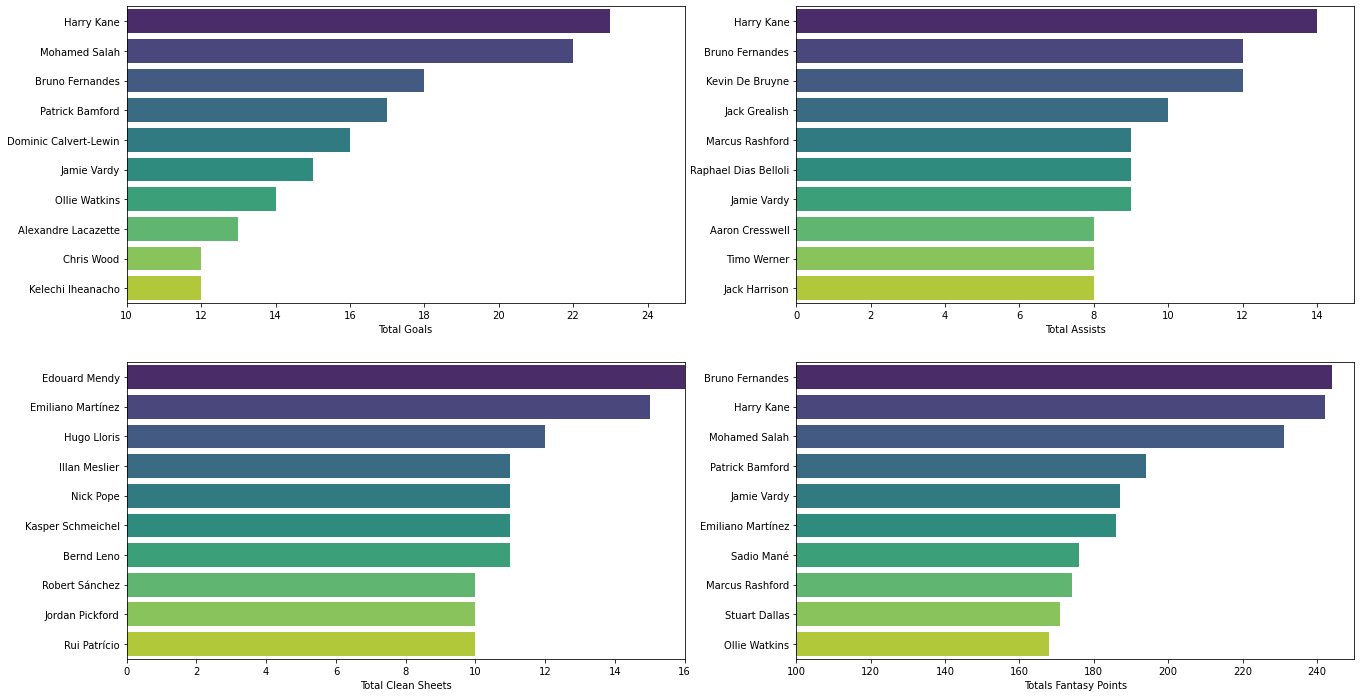

In [10]:
# Goals
fig, ax = plt.subplots(2,2, sharey=False, figsize=(22,12))

df_eda = pd.read_sql('select * from overlap', engine)

# Create dataframe to filter goals and players
df_goals = df_eda.sort_values\
(by='gls', ascending=False)[['player','gls']].head(10)

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b>Figure 5.1 Top 10 Players by Statistics</b></center>'))

# Show Top 10 players by goals plot
sns.barplot(x=df_goals["gls"],
            y=df_goals["player"],
            palette='viridis',
            ci='None',
            capsize=1,
            ax=ax[0][0])

# Assists
# Create dataframe to filter assists and players
df_assists = df_eda.sort_values\
(by='ast', ascending=False)[['player','ast']].head(10)

#Show Top 10 players by assists plot and players
sns.barplot(x=df_assists["ast"], 
            y=df_assists["player"],
            palette='viridis',
            ci='None',
            capsize=1,
            ax=ax[0][1])

# Clean Sheets
# Create dataframe to filter cleansheets and players
df_cleansheets = df_eda.sort_values\
(by='cs', ascending=False)[['player','cs']].head(10)

#Show Top 10 players by clean sheet
sns.barplot(x=df_cleansheets["cs"],
            y=df_cleansheets["player"],
            palette='viridis',
            ci='None',
            capsize=1,
            ax=ax[1][0])

# Fantasy Points
# Create dataframe to filter fantasy points and players
df_points = df_eda.sort_values\
(by='total_points', ascending=False)[['player','total_points']].head(10)

# Show Top 10 players by fantasy points

sns.barplot(x=df_points["total_points"],
            y=df_points["player"],
            palette='viridis',
            ci='None',
            capsize=1,
            ax=ax[1][1])

ax[0][0].set(xlabel='Total Goals', ylabel='')
ax[0][0].set_xlim(10,25)
ax[0][1].set(xlabel='Total Assists', ylabel='')
ax[0][1].set_xlim(0,15)
ax[1][0].set(xlabel='Total Clean Sheets', ylabel='')
ax[1][0].set_xlim(0,16)
ax[1][1].set(xlabel='Totals Fantasy Points', ylabel='')
ax[1][1].set_xlim(100,250)

plt.show()

<div style="text-align: justify">The most important individual player statistics that we want to highlight are <b>Goals, Assists, Clean Sheets, and Fantasy Points.</b></div>

- <div style="text-align: justify">A <b>goal</b> is scored when the ball passes completely over a goal line at either end of the field of play between two centrally positioned upright goal posts. It is awarded to an offensive player who either kicks or heads the football into a goal post. This statistic is very important as the winner of a match is the team that scores more goals within a match period. In the 2020-2021 edition of the English Premier League, Harry Kane from club Tottenham Hotspur scored the most number of goals at a whopping 23 goals for the whole season, averaging almost 1 goal per match. Coming in second place and just a single goal behind the top scorer is forward Mohamed Salah from Liverpool. Manchester United's midfielder Bruno Fernandes, Leeds United's forward Patrick Bamford, and Everton's forward Dominic Calvert-Lewin occupy the rest of the top five scorers with 18, 17, and 16 goals scored respectively. The rest of the top ten scored 12-15 goals.</div><br>

- <div style="text-align: justify">An <b>assist</b> is credited to a player for passing or crossing the ball to the scorer. It may also be awarded to a player whose shot rebounds either off a defender, goalkeeper or goalpost, to a teammate who scores. Some systems may credit an assist to a player who wins a penalty kick or a free kick for another player to convert, or to an attacking player for contributing to an own goal. Assists are crucial in football because it is a team sport and players are able to contribute by helping to score a goal. Similar to goals, forward Harry Kane tops the list with 14 assists in the whole season. He is followed close by Manchester United's Bruno Fernandes and Kevin de Bryune from Manchester City both with 12 assists. The rest of the top ten players for this game statistic gathered 8-11 assists. </div><br>

- <div style="text-align: justify">A <b>clean sheet</b> is a term that describes a game where a team managed to prevent its opponents from scoring goals. A team achieves a clean sheet when they don’t concede to a goal during the said game. The no-score-draw scenario makes it possible for both teams to keep a “clean sheet”. In American soccer, the term is commonly called “Shutout” as opposed to "clean sheet" by the British. </div><br>
<div style="text-align: justify">Clean sheets are rewarded to goalkeepers and are relatively difficult to achieve since football is a very competitive team sport with a lot of talented players. For the 2020-2021 edition of the English Premier League, Chelsea's goalkeeper Edouard Mendy had the highest tally at 16 for matches where the opponent failed to score a single goal. Emiliano Martinez, the goal keeper from Aston Villa and Hugo Lloris from Tottenham Hotspur follow by having 15 and 12 clean sheets. Other goalkeepers in the top ten had clean sheets ranging from 10 to 11 games.</div><br>

- <div style="text-align: justify"><b>Fantasy points</b> are calculcated based on individual game player statistics. During the English Premier League season, fantasy football players were allocated points based on their performance. Manchester United's Bruno Fernandes led all players across all teams by scoring 244 fantasy points in the 2020-2021 edition of the English Premier League. Coming in on second and third place are Tottenham Hotspur's Hary Kane with 242 fantasy points and Liverpool's Mohamed Salah at 231. Finishing the top five are Leeds United's Patrick Bamford at 194 and Jamie Vardy from Leicester City with 187 fantasy points. The rest of the top ten's fantasy points are from 168 to 186. It is interesting to note that the top players by fantasy points are also at at the top of the list for goals and assists. </div>

### 5.1.2 Statistics by Fantasy Points

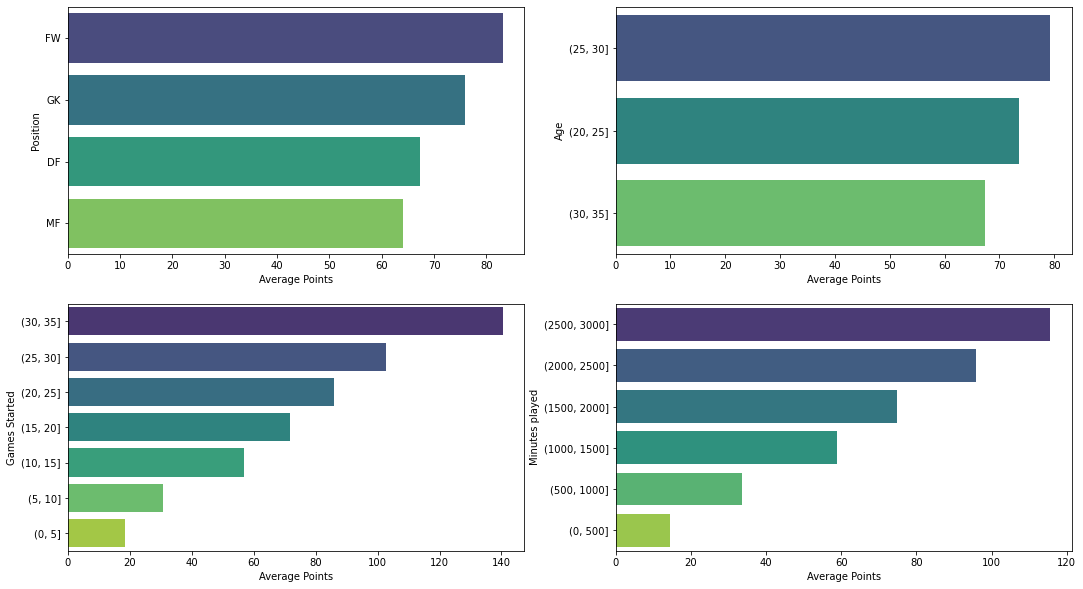

In [11]:
# Positions
fig, ax = plt.subplots(2,2, sharey=False, figsize=(18,10))

pos_points = df_eda.groupby('pos', as_index=False)['total_points'].mean()
pos_points.sort_values('total_points', ascending=False, inplace=True)

#Plot age
sns.barplot(y='pos',
            x='total_points',
            data=pos_points,
            palette='viridis',
            ax=ax[0][0])

# Create a dataframe for age vs total points 
age_points = df_eda.copy()
minage = age_points['age'].min()
maxage = age_points['age'].max()
age_range = np.arange(20, 40, 5)
age_points = (age_points.groupby(pd.cut(age_points["age"],
                                age_range))['total_points'].mean())
age_points = age_points.reset_index()
age_points = age_points.astype({'age': 'str'})
age_points.sort_values('total_points', ascending=False, inplace=True)

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.2 Statistics by Fantasy Points'
             '</b></center>'))

# Plot age vs total points
sns.barplot(x='total_points',
            y='age',
            data=age_points,
            palette="viridis",
            ax=ax[0][1])

# Create a dataframe for started vs total points bar chart
start_points = df_eda.copy()
minstart = start_points['starts'].min()
maxstart = start_points['starts'].max()
start_range = np.arange(0, 40, 5)
start_points = (start_points.groupby(pd.cut(start_points["starts"],
                                start_range))['total_points'].mean())
start_points = start_points.reset_index()
start_points = start_points.astype({'starts': 'str'})
start_points.sort_values('total_points', ascending=False, inplace=True)

# Plot rate vs duration bar chart
sns.barplot(x='total_points',
            y='starts',
            data=start_points,
            palette="viridis",
            ax=ax[1][0])

# Create a dataframe for min vs total points bar chart
min_points = df_eda.copy()
minminutes = min_points ['min'].min()
maxminutes = min_points ['min'].max()
min_range = np.arange(0, 3500, 500)
min_points = (min_points .groupby(pd.cut(min_points ["min"],
                                min_range))['total_points'].mean())
min_points = min_points .reset_index()
min_points  = min_points .astype({'min': 'str'})
min_points.sort_values('total_points', ascending=False, inplace=True)

# Plot rate vs duration bar chart
sns.barplot(x='total_points',
            y='min',
            data=min_points,
            palette="viridis",
            ax=ax[1][1])

ax[0][0].set(xlabel='Average Fantasy Points', ylabel='Position')
ax[0][1].set(xlabel='Average Fantasy Points', ylabel='Age')
ax[1][0].set(xlabel='Average Fantasy Points', ylabel='Games Started')
ax[1][1].set(xlabel='Average Fantasy Points', ylabel='Minutes played')

plt.show()

In this section, we will look into Fantasy Football Points by correlating it with other important features and player statistics.

- <div style="text-align: justify"><b>Position</b>. As seen in the chart displaying Fantasy Points versus football player positions on the upper left section above, forwards have the highest points, with an average of 80. Forwards are those who play nearest to the opposing team's goal, and are therefore most responsible for scoring goals. Their advanced position and limited defensive responsibilities mean forwards normally score more goals on behalf of their team than other players. Goalkeepers follow the fowards in terms of fantasy points with an average of around 75 while defenders and midfielders average 63 to 65 total fantasy points. </div><br>
- <div style="text-align: justify"><b>Age.</b> It is common in football and sports in general to assume that as athletes age, their performance slows down and affects their individual playing statistics. There is also the concept of reaching your peak performance at a certain age. Several studies provide some proof on the relationship between age and performance in football. Some of the conclusions are as follows and we quote from the <b>Barcelona Innovation hub</b>: </div><br>

     <div style="text-align: justify">"There is a clear loss of physical performance in players over 30 years compared to younger footballers. After analysing 10,739 players from the Spanish La Liga during the 2017-2018 season, three researchers discovered that the total distance covered by players over 30 is 2% lower than that covered by younger players. The distance covered, the number of high intensity efforts or sprints and the maximum speed reached also decreased significantly, between 5 and 30%. The loss of performance is especially drastic in those over 35. This trend was noted across all positions, even though players on the wings (wing backs and wingers) appear to experience a lower loss of performance level. This evolution of performance has also been observed in players taking part in the German Bundesliga. The total distance covered, the number of sprints (faster than 6.3 m/s for at least 1 second) and the number of fast races (faster than 5.0 m/s for at least 1 second) decreased by 3.4%, 21% and 12% respectively in players over 30 compared with younger footballers." </div><br>
    
    <div style="text-align: justify">These conclusions are very interesting since our data coincides with what they say. In the above bar chart on age versus Fantasy Fooball points, football player ages range from as young as 20 years old to 35 years of age. The age range that scored the highest average fantasy points at 79 is the 25-30 bracket. This is followed close by the 20-25 age bracket for football players that average around 73 fantasy points. Coming in last is the 30-35 age range, averaging close to 70 points. </div><br>
- <div style="text-align: justify"><b>Games Started and Minutes Played.</b> Being a starter player and playing more minutes of football positively correlates to having higher fantasy points. This is due to the fact that there is more time and chances to perform and boost individual statistics such as passes and goals. In the lower right portion of the chart above, it could be seen that those who played a total of 2500 to 3000 minutes in the English Premier League had the lowest total fantasy points while those who had limited time of 0 to 500 garned the lowest.

### 5.1.3 Club Statistics

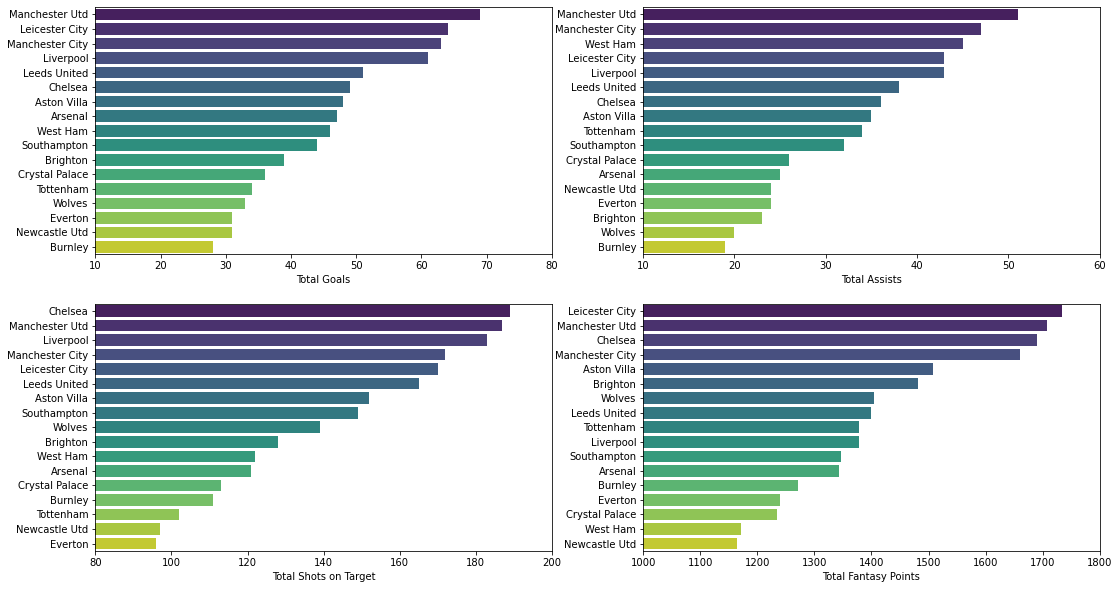

In [12]:
# Remove teams not included in the 2020-2021 season
df_eda = df_eda[df_eda.squad != 'West Brom']
df_eda = df_eda[df_eda.squad != 'Fulham']
df_eda = df_eda[df_eda.squad != 'Sheffield Utd']

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.3 Club Statistics(Offense)'
             '</b></center>'))

# Team offense stats
fig, ax = plt.subplots(2, 2, sharey=False, figsize=(18,10))

# Team goals
goals = df_eda.groupby('squad', as_index=False)['gls'].sum()
goals.sort_values('gls', ascending=False, inplace=True)

sns.barplot(y='squad', x='gls', data=goals, palette='viridis',
           ax=ax[0][0])

# Team assists
assists = df_eda.groupby('squad', as_index=False)['ast'].sum()
assists.sort_values('ast', ascending=False, inplace=True)

sns.barplot(y='squad', x='ast', data=assists, palette='viridis',
           ax=ax[0][1])

# Team fantasy points
total_points = df_eda.groupby('squad', as_index=False)['total_points'].sum()
total_points.sort_values('total_points', ascending=False, inplace=True)

sns.barplot(y='squad', x='total_points', data=total_points, 
            palette='viridis', ax=ax[1][1])

# Team shots on target
sot = df_eda.groupby('squad', as_index=False)['sot'].sum()
sot.sort_values('sot', ascending=False, inplace=True)

sns.barplot(y='squad', x='sot', data=sot, palette='viridis',
           ax=ax[1][0])

ax[0][0].set(xlabel='Total Goals', ylabel='')
ax[0][0].set_xlim(10,80)
ax[0][1].set(xlabel='Total Assists', ylabel='')
ax[0][1].set_xlim(10,60)
ax[1][1].set(xlabel='Total Fantasy Points', ylabel='')
ax[1][1].set_xlim(1000,1800)
ax[1][0].set(xlabel='Total Shots on Target', ylabel='')
ax[1][0].set_xlim(80,200)


plt.show()

<div style="text-align: justify">Data of participating football teams was also analyzed and the prominent offensive and defensive stats per Premier League team were highlighted. The first set of graphs are for offense-related statistics. Manchester United led all teams in total goals and assists last season. Meanwhile, Chelsea attempted the most shots on target. It is notable that the top teams with highest accumulated fantasy points, are also the same teams that rank high on the offensive statistics. </div>

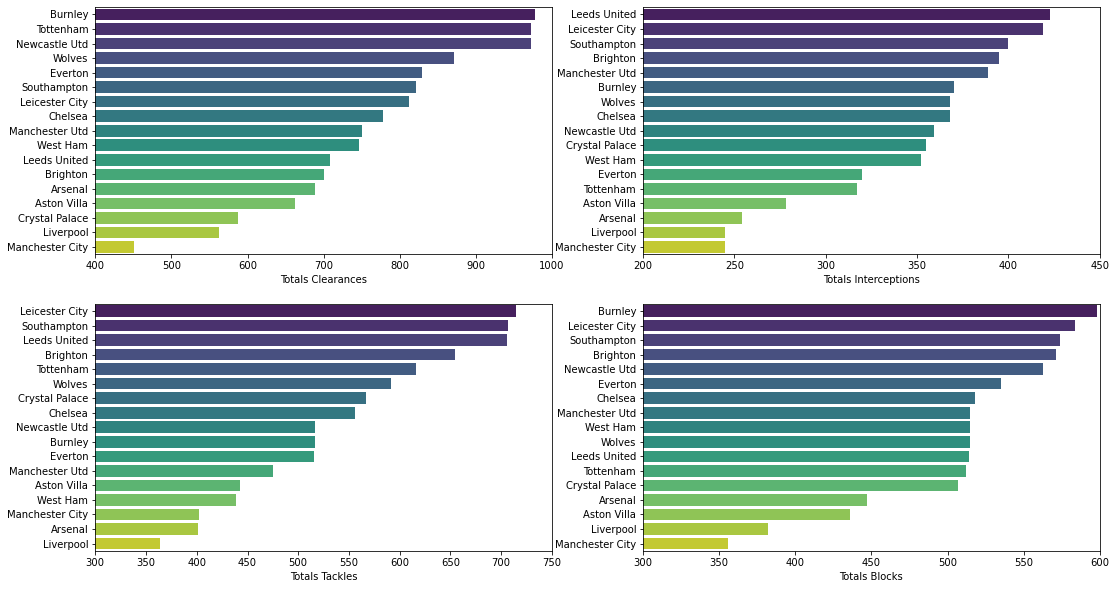

In [13]:
# Defense stat plots
fig, ax = plt.subplots(2, 2, sharey=False, figsize=(18,10))

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.4 Club Statistics(Defense)'
             '</b></center>'))

# Team clearance
clearance = df_eda.groupby('squad', as_index=False)['clr'].sum()
clearance.sort_values('clr', ascending=False, inplace=True)

sns.barplot(y='squad', x='clr', data=clearance, palette='viridis',
           ax=ax[0][0])

# Team interceptions
inter = df_eda.groupby('squad', as_index=False)['int'].sum()
inter.sort_values('int', ascending=False, inplace=True)

sns.barplot(y='squad', x='int', data=inter, palette='viridis',
           ax=ax[0][1])

# Team tackles
tackles = df_eda.groupby('squad', as_index=False)['tkl'].sum()
tackles.sort_values('tkl', ascending=False, inplace=True)

sns.barplot(y='squad', x='tkl', data=tackles, palette='viridis',
           ax=ax[1][0])

# Team blocks
blocks = df_eda.groupby('squad', as_index=False)['blocks'].sum()
blocks.sort_values('blocks', ascending=False, inplace=True)

sns.barplot(y='squad', x='blocks', data=blocks, palette='viridis',
           ax=ax[1][1])

ax[0][0].set(xlabel='Totals Clearances', ylabel='')
ax[0][0].set_xlim(400, 1000)
ax[0][1].set(xlabel='Totals Interceptions', ylabel='')
ax[0][1].set_xlim(200,450)
ax[1][0].set(xlabel='Totals Tackles', ylabel='')
ax[1][0].set_xlim(300,750)
ax[1][1].set(xlabel='Totals Blocks', ylabel='')
ax[1][1].set_xlim(300,600)

plt.show()

<div style="text-align: justify">On the other hand, different teams lead each statistic for defensive-related figures but the notable team that was always at the top 3 teams was Leicester City. Burnley and Leeds United also have great defensive numbers. It is also noteworthy that the more offensive-minded team from the graphs above tend to score lower in the defensive statistics. This may probably be due to the fact that these teams have the ball most of the time during the game, thus requiring them to defend less.</div>

### 5.1.4 Positions

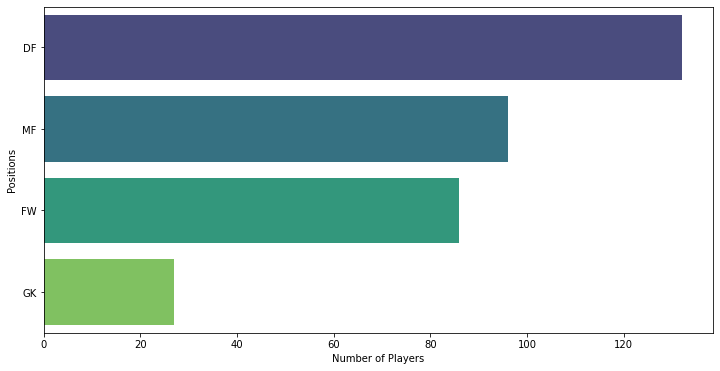

In [14]:
# Plot Positions Bar Chart
nation = df_eda.groupby('pos', as_index=False)['player'].count()
nation.sort_values('player', ascending=False, inplace=True)

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.5 Player Distribution per Position '
             '</b></center>'))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(y='pos', x='player', data=nation, palette='viridis', ax=ax);
ax.set_xlabel('Number of Players')
ax.set_ylabel('Positions');

Our data  from the 2020-2021 English Premier League season shows that around 130 Defenders, nearly 100 Midfielders, close to 90 forwards, and around 30 goalkeepers participated in the games. 

### 5.1.5 Nationality

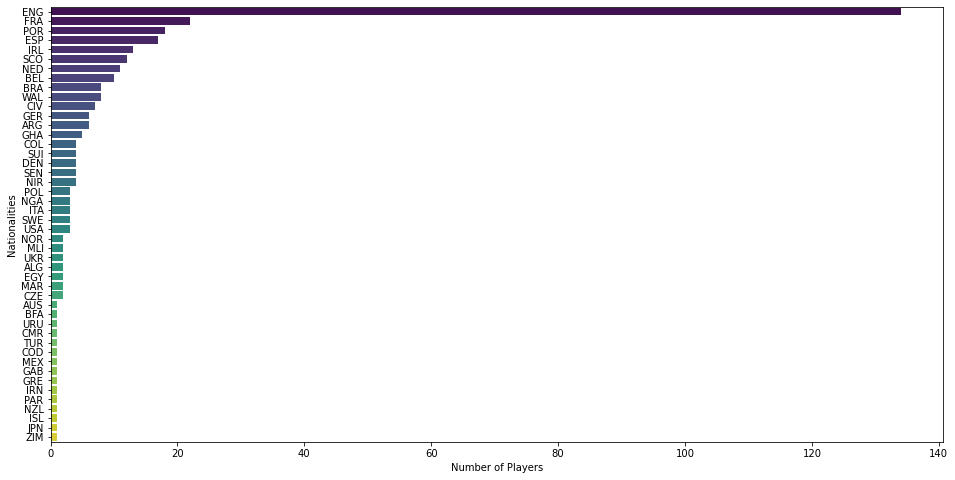

In [15]:
# Plot Nationality Bar Chart
nation = df_eda.groupby('nation', as_index=False)['player'].count()
nation.sort_values('player', ascending=False, inplace=True)

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.6 Player Distribution by Nationality'
             '</b></center>'))

fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(y='nation', x='player', data=nation, palette='viridis', ax=ax);
ax.set_xlabel('Number of Players')
ax.set_ylabel('Nationalities');

<div style="text-align: justify">As expected, the English Premier League is dominated by British players. Some sources consider the league today as much more intercontinental than it was when it was launched in 1992. Although dominated by players from the UK, there are now more players from other parts in Europe, North and South America, Asia, Africa and Australia whereas in 1992 it was mainly Europe and North America. It is also known that nations such as France, Spain, Brazil and Portugal have become big sources of talent for the Premier League in the last number of years. This is backed up by our data through the distribution of nationalities visualized in the bar plot above.</div><br>

<div style="text-align: justify">According to Liam McGuirk, "Globalisation has had a massive impact on football as a whole," as  it has allowed clubs to find talent abroad and also increase the popularity of the Premier league in countries all over the world. He continues by saying that "when a foreign national joins a Premier League club this brings a lot more than just the player in the end. Advertisement has a brand new opportunity as the club can now expand their advertisement to that country in the form of promoting the Premier League in that country and also promoting the player at his new club." This in effect will attract viewers from new areas to the club most like likely because their favourite player is actively playing there. As a result, sales will increase for that club. These clubs then have an even larger market for products such as jersys and kits,  increasing massively in the country the player has come from. Furthermore, it will also increase revenue for broadcast companies because the Premier League may be broadcasted and shown on TV in more countries.</div>


## 5.2 Dimensionality Reduction

### Principal Component Analysis

<div style="text-align: justify">Principal Component Analysis was done on the <b>overlap</b> data set. The aim is to reduce the size of our data by identifying principal components that can represent most of our information. The team also wants to see the correlation of the features with each other. In this analysis we incuded all of the columns including the <b>fantasy_points</b> target column to see its underlying correlation with other features.</div>

<div style="text-align: justify">Upon checking, to represent <b>90%</b> of our explained variance, we will be needing <b>9 principal components</b>.</div>

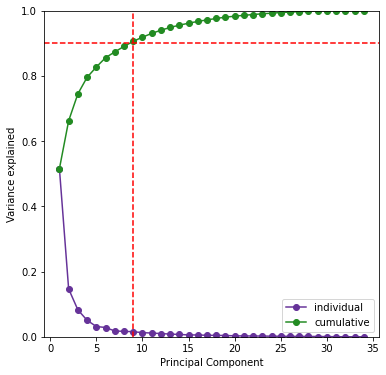

In [16]:
# Prepare dataset for PCA
df = pd.read_sql('select * from overlap', engine)
df_pca = df.drop(['player', 'nation', 'pos', 'squad', 'age'], axis=1)

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.7 Scree Plot for Explained Variance'
             '</b></center>'))

# Define X
X = df_pca
features = df_pca.columns

# Scaling
sscaler = MinMaxScaler()
X_norm = sscaler.fit_transform(X.astype(np.float))
X_norm_df = pd.DataFrame(data = X_norm, columns = features)
X_norm_df

X_new, w, variance_explained = pca(X_norm)

# Scree plot
fig, ax = plt.subplots()
ax.plot(range(1, len(variance_explained)+1), variance_explained, 'o-', 
        color='rebeccapurple', label='individual')
ax.plot(range(1, len(variance_explained)+1), variance_explained.cumsum(), 
        'o-', color='forestgreen', label='cumulative')
ax.legend()
ax.set_ylim(0, 1)
ax.set_xlabel('Principal Component')
ax.axhline(0.90, ls='--', color='r')
ax.axvline(9, ls='--', color='r')
ax.set_ylabel('Variance explained');

<div style='text-align: justify;'>These 9 principal components were plotted against each other via biplots to see if there are trends or themes that we can relate to each PC or dimension. </div> <br>

<div style='text-align: justify;'>Various interpretations can be attributed to the principal components depending on the correlated features that the biplot shows.</div> <br>
    
<div style='text-align: justify;'>Here are some of our takes in interpreting the new dimensions: </div>

<div style='text-align: justify;'> <b>PC1</b> shows a clear divide between players and non-players. All the features are pointing towards the negative side of the PC which suggests that there is a boundary. There seems to be a void or lack of data plotted at the positive side which indicates a zone for non-players. The nature of the features having a lower bound of zero might also be a cause of this plot concentration. </div> <br>

<div style='text-align: justify;'> Analyzing <b>PC2</b> even makes the observation more interesting. If plotted against PC1, it shows an almost equal divide of features going to both the positive and negative side. All goalkeeping features are close to the origin. Meanwhile, the features positively correlated to PC2 are mostly stats related to offense. Most notable with the greatest weights are goals, assists, total shots,and shots on target-- shot creating actions which are all attributed to attacking players. Meanwhile those pointing towards the negative axis of PC2 are features attributed to the defensive side of play, for example, clearances, interceptions, recoveries, and blocks.</div> <br>

<div style='text-align: justify;'> <b>PC1 and PC2</b>, accounting for 52% and 15% respectively of the explained variance, shows the best possible plot for the player data points. The biplot starts at the origin where most of the goalkeepers are and as it goes to left, the two types of players, attacking and defending, are diverging from each other. It is also good to note that the total points feature is more correlated to the attacking players. </div> <br>

<div style='text-align: justify;'> As for the other PCs, some of them can be given a clear reading but most are uninterpretable.</div>

<div style='text-align: justify;'> <b>PC3</b> could be a dimension for highlighting goalkeeper skills, because the skills like clean sheets, penalty, and shot saves are pointing towards one of its axes at almost full weight. This is also the dimension where total points is correlated to the goalkeeper stats. As for the other features in the PC3 plots, there are no clear correlations between them.</div> <br>

<div style='text-align: justify;'> <b>PC4</b> can be related to precision kickers due to the following features all pointing towards its negative axis: throw-ins, corner kicks, crosses, and assists which all pertain to the ability to place the ball in the perfect location.</div> <br>

<div style='text-align: justify;'> <b>PC5</b> can be described with a spectrum of defenders to midfielders.  On one side we have aggressive defending features like tackles, presses, fouls and even number of yellow cards. Meanwhile on the other side, features describe more of the ball controlling game with correlated features like received passes, completed passes, ball carries and touches. Total points are slightly more correlated to the ball control features.</div>

<div style='text-align: justify;'> <b>PC6</b> shows a good split of features but there are no obvious interpretations based on the correlated features. </div><br>
    
<div style='text-align: justify;'> Meanwhile, for <b>PC7</b> it seems to be that the weight of the features are at a minimum for both axes.</div> <br>

<div style='text-align: justify;'> <b>PC8 and PC9</b> show correlation between features like completed and received passes, ball carries, and dribbles which describe the midfielder’s type of play just like in PC5. It is notable that as the explained variance decreases it also becomes more difficult to interpret these dimensions.</div>

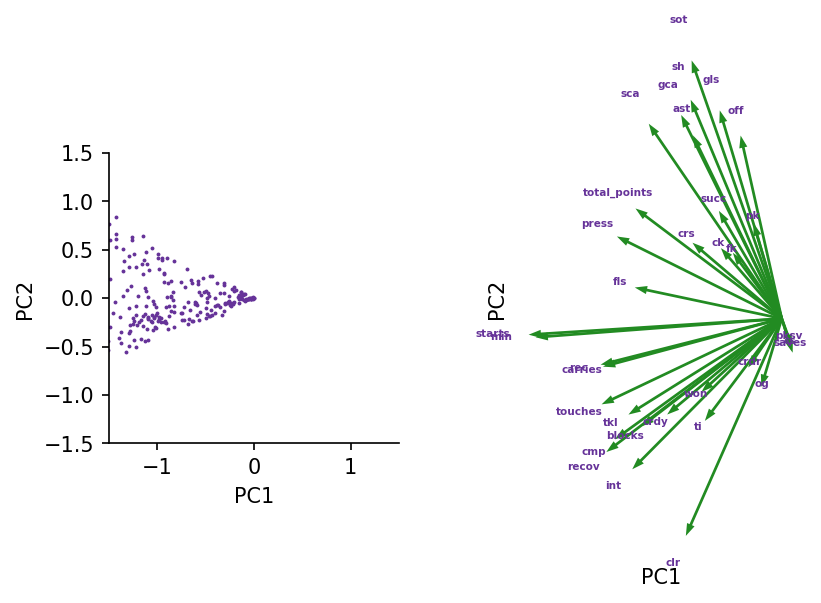

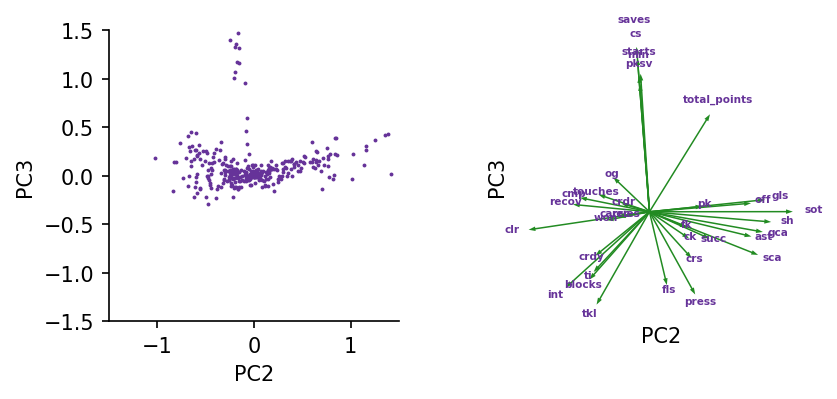

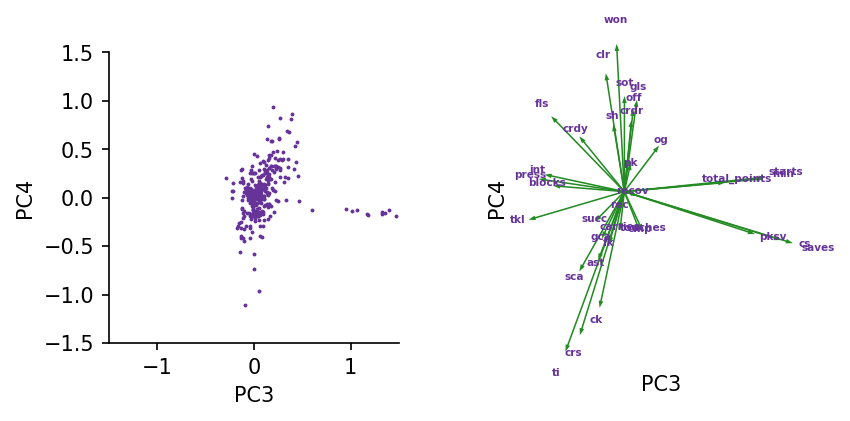

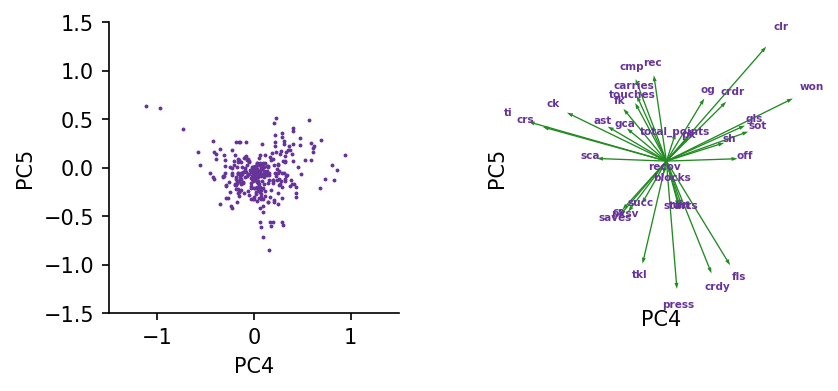

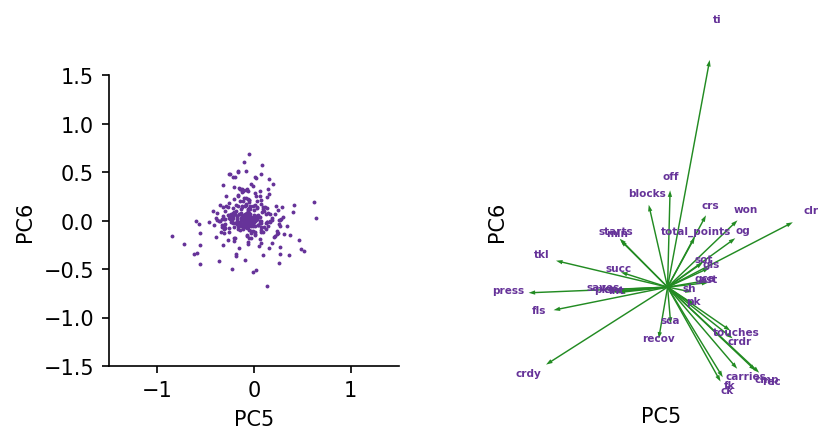

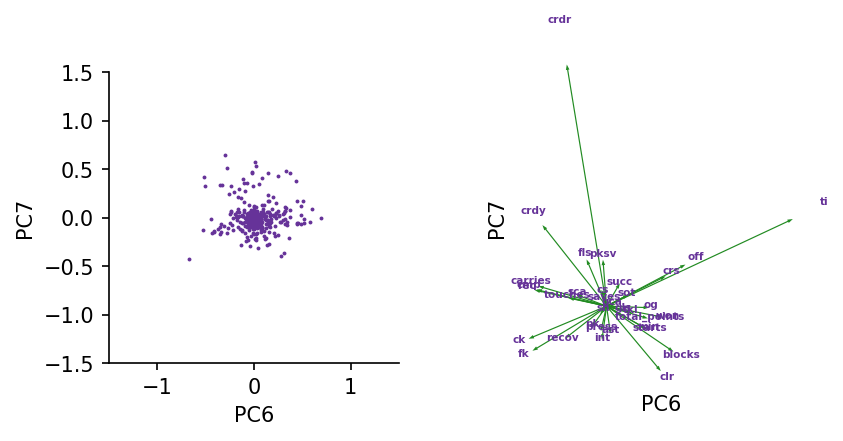

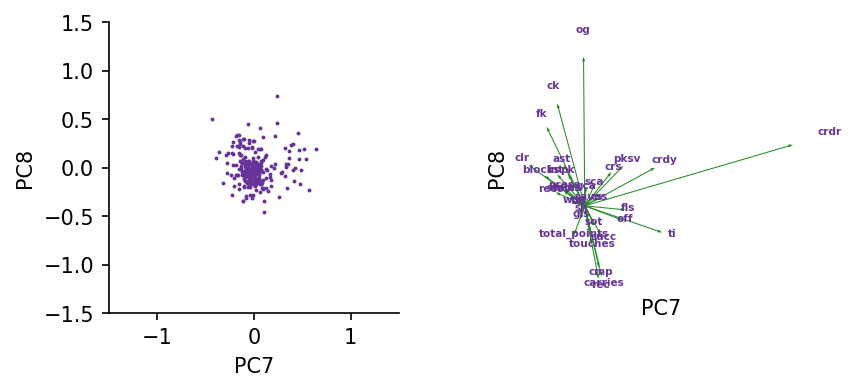

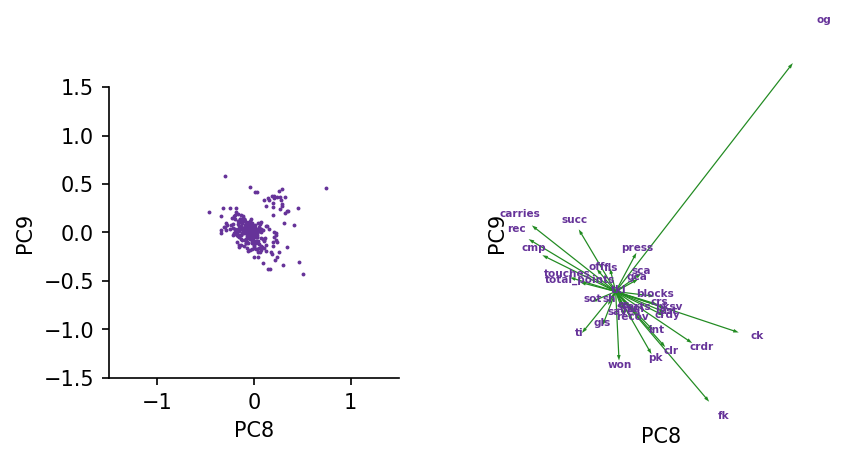

In [17]:
# Define number of PCs
pc_total = 9 
X_new = X_norm.dot(w[:, :pc_total])

#Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.8 Principal Component Biplots'
             '</b></center>'))

# Plot biplots for PCs
plot_pca(X_new, features, w, pc_total)

## 5.3 Machine Learning Models


<div style='text-align: justify;'> Since we already completed Principal Component Analysis, we complemented the method with some basic machine learning models specifically k-NN regressor and linear regressors Ridge and Lasso. In the process of implementing Principal Component Regression <b>(PCR)</b>, we decided to use the truncated matrix or subset of the principal components based on the explained variance that it represents <b>(90%)</b>. </div> <br>

<div style='text-align: justify;'> The data set was prepared and split into a hold-out (20% of the data) set and a training set. The target data is the <b>total fantasy points</b> represented by the column <b>total points</b>. This column was dropped prior to the model training. We tried to see if there will be an effect on the model’s accuracy if we only use a portion of the representative dimensions or principal components instead of using all the original features.</div>

### 5.3.1 Principal Component Regression

<div style='text-align: justify;'> In the interest of comparison, we ran another PCA on the data but this time we did not include the target feature in the analysis. We still got the same number of PCs for a 90% explained variance which is 9. We then proceeded with the machine learning models and got the following results: </div>

In [18]:
# Rerun PCA but remove the target variable total_points
df_pca_ml = df.drop(['player', 'nation', 'pos', 'squad', 'age', 
                  'total_points'], axis=1)
features = df_pca_ml.columns

# Scaling
sscaler = MinMaxScaler()
X_norm = sscaler.fit_transform(df_pca_ml.astype(np.float))
X_norm_df_ml = pd.DataFrame(data = X_norm, columns = features)

# PCA
X_new_ml, w_ml, variance_explained = pca(X_norm_df_ml)

# Truncate
pc_total = 9 
X_new2 = X_norm_df_ml.dot(w_ml[:, :pc_total])
#X_new2 = np.array(X_new_ml)[:, :9]

# Merge PC subset and target column
df_ml = pd.DataFrame(X_new2)
df_ml['total_points'] = list(df['total_points'])

pcs = df_ml.drop(['total_points'], axis=1)
target = df_ml['total_points']

# Define X and y
X = pcs
y = target

,Machine Learning Method,Train Accuracy,Validation Accuracy,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.791868,0.739452,0.756816,N_Neighbor = 9,NA,2.115467
1,Ridge,0.825675,0.807482,0.800087,Alpha = 1.5,PC3,1.483956
2,Lasso,0.826754,0.807439,0.796923,Alpha = 0.1,PC3,1.515657
3,Linear Regression,0.827688,0.805290,0.797120,NA,PC3,3.056944


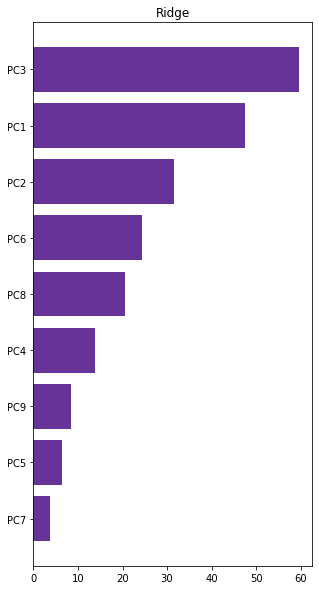

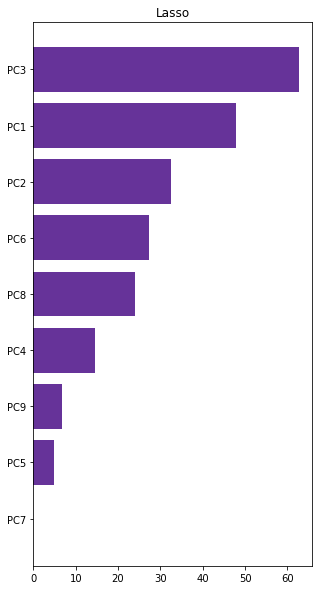

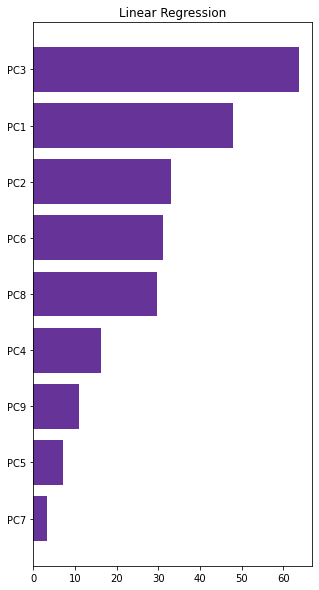

In [19]:
# Results table
cols = ['Machine Learning Method', 'Train Accuracy', 'Validation Accuracy',
        'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 
        'Run Time']
df_results = pd.DataFrame(columns=cols)

Number_trials = 20
column_names = np.array(['PC1', 'PC2', 'PC3', 'PC4', 'PC5',
                         'PC6', 'PC7', 'PC8', 'PC9'])

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.9 Machine Learning Results for PCR'
             '</b></center>'))

df_results.loc[0] = train_knn(X, y)
df_results.loc[1] = train_ridge(X, y)
df_results.loc[2] = train_lasso(X, y)
df_results.loc[3] = train_linreg(X, y)

df_results

<div style='text-align: justify;'> We can see that test accuracies for the hold out dataset <b>(Test Accuracies)</b> were comparable to each other, ranging from 75-80%. The runtimes are short and the identified best predictor for all the models is <b>PC3</b>. This is followed by PC1 and PC2 for all models as well. </div><br>

<div style='text-align: justify;'>The results were consistent because we know that these 3 principal components contain the most information or variance about our initial dataset. The only problem with this method is that the interpretation is not straightforward as the PCs are defined arbitrarily. If we recall from the dimensionality reduction discussion, <b>PC3</b> was described in the previous discussion as a dimension focused on <b>goalkeeping skills</b> which is correlated to the total fantasy points, meanwhile PC1 describes the general difference from players and non-players and PC2 describes and actually differentiates attacking versus defending players, with the total fantasy points feature more correlated to attacking player statistics. </div>

### Machine Learning Using the Original Dataset
<br>
<div style='text-align: justify;'> The models were trained again using the original dataset this time. We also scaled the data accordingly before training the model and got the following results: </div>

In [20]:
# Define dataset features and target
features_ml = df.drop(['player', 'nation', 'pos', 'squad',
                       'total_points'], axis=1)
target_ml = df['total_points']

# Scaling
sscaler = MinMaxScaler()
X_norm = sscaler.fit_transform(features_ml.astype(np.float))
X_norm_ml = pd.DataFrame(data = X_norm, columns = features_ml.columns)

# Define X and y
X = X_norm_ml
y = target_ml

,Machine Learning Method,Train Accuracy,Validation Accuracy,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.790432,0.734833,0.739775,N_Neighbor = 8,NA,63.431387
1,Ridge,0.859038,0.824589,0.805200,Alpha = 0.4,gls,1.576611
2,Lasso,0.862483,0.828758,0.805996,Alpha = 0.05,gls,9.744628
3,Linear Regression,0.870271,0.809478,0.795430,NA,touches,3.090091


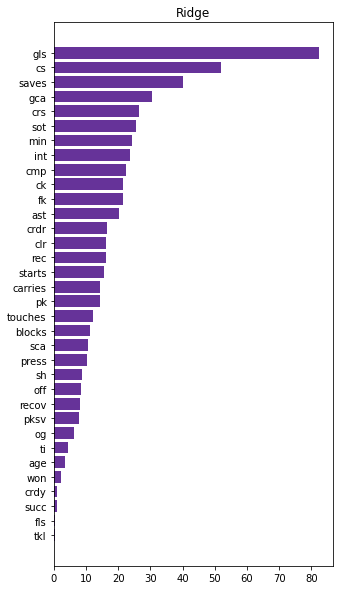

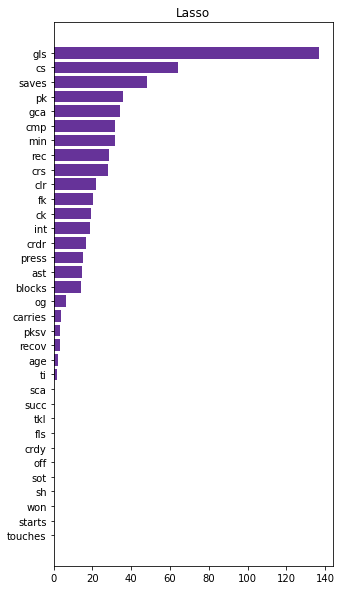

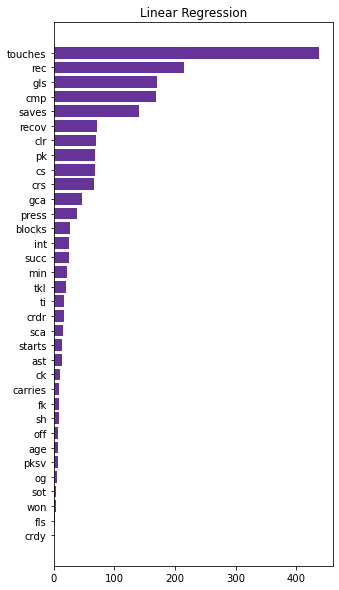

In [21]:
# Results table
cols = ['Machine Learning Method', 'Train Accuracy', 'Validation Accuracy',
        'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 
        'Run Time']
df_results = pd.DataFrame(columns=cols)

Number_trials = 20
column_names = features_ml.columns

# Display Caption
display(HTML('<center style="font-size:12px;font-style:default;">'
             '<b> Figure 5.10 Machine Learning Results for Original Features'
             '</b></center>'))

df_results.loc[0] = train_knn(X, y)
df_results.loc[1] = train_ridge(X, y)
df_results.loc[2] = train_lasso(X, y)
df_results.loc[3] = train_linreg(X, y)

df_results

<div style='text-align: justify;'> As can be seen, the test accuracies are of almost the same value as from the first set of results. kNN accuracy was worse, meanwhile the other models vary by less than 1%. The biggest difference is the runtime which are all longer compared to the first run. This is due to the size of our dataset being larger than the PCA subset. </div> <br>

<div style='text-align: justify;'>The positive thing with this is that the interpretation is more straightforward specially when it comes to the top predictors. It is identified here that the top variables are either goals <b>(gls)</b> or <b>touches</b>. But looking at the other top features will reveal that they are <b>goalkeeping related features</b> like clean sheets <b>(cs)</b> and penalty <b>saves</b>, which is the same as what PC3 was representing.  Other top features are goal creating actions <b>(gca)</b>, passes completed <b>(cmp)</b> and penalty kicks taken <b>(pk)</b>, together with goals and touches, are all features related to <b>attacking players</b>, same as what PC2 describes.</div> <br>

<div style='text-align: justify;'> There are also some features with consistently low weights or coefficients like fouls <b>(fls)</b>, tackles <b>(tkl)</b> and yellow cards <b>(crdy)</b>. </div> <br>

<div style='text-align: justify;'>To summarize, we had comparable results for the accuracies in both methods, but the runtimes were faster for the PCR method. This is due to fewer dimensions in the dataset that will be trained. Meanwhile for interpretability, it was harder to do it for the PCR but if analyzed, interpretations from both methods actually match.</div> 

## 6. Conclusion and Recommendation


<div style='text-align: justify;'>The fame of football has spanned decades as well as geographical continents and has captured the hearts of millions of fans all over the world. Since it started in 1992, the English Premier League has become a worldwide phenomenon, the gold standard in player quality, match viewership,  and game attendance. Fantasy football has also attracted millions of fans and sports enthusiasts alike to carefully peruse details of the game, putting a spotlight on team performance and individual football player statistics.</div><br>

<div style='text-align: justify;'>Our group found out that attacker statistics contribute greatly to total Fantasy football points. This can be evidently seen as our data exploration graphs show that high-ranked attackers in individual offense-related statistics also place high in the list of players with the highest fantasy points.  This insight is also supported by our Principal Component Analysis findings where the features most positively correlated to fantasy points are stats related to attack or offense. Those with the highest weights are goals, assists, total shots,and shots on target-- all shot-related actions that are attributed to attacking players.  These features rank high in our Principal Component Machine Learning model as one of the top predictors for fantasy points represented by Principal Component 2(PC2). The case was the same when we used the original features and the offensive stats all ranked as part of the top predictors in our machine learning models.</div><br>

<div style='text-align: justify;'>We also found out that goalkeeper statistics, although exclusive for goalkeepers, are also highly correlated to total fantasy points. Goalkeepers together with attackers had the higher average total fantasy points compared to other players. This is also consistent with our PCA findings that show one of our Principal Components, PC3, a dimension for highlighting goalkeeper skills like clean sheets, penalty, and shot saves as positively related to total fantasy points. Furthermore, Principal Component 3(PC3) was the top predictor for all PCR machine learning models and the goalkeeper stats were among the top predictors in our ML models that used the original features. Other features to be noted like defensive statistics are correlated but do not contribute as much to total fantasy points. Also, the rest of the features like fouls, yellow cards, and tackles have low weights and do not greatly affect total points.</div><br>

<div style='text-align: justify;'>Our group recommends future proponents or researchers who are interested in this topic to delve further into the problem at hand. They can start by expanding their dataset and utilize other pertinent statistics found on our source websites or other sources of information. They can use the Lasso machine learning method first before delving into Principal Component Analysis so as to remove or drop features with very low weights or impact. Such researchers can try out other machine learning models in their portfolio to further test their chosen features in predicting total fantasy points. We also suggest that future researchers run and execute separate analyses and investigations on goalkeepers statistics as they are very unique and might need a closer look. Finally, other football leagues may be compared to the English Premier League in determining the features and statistics that contribute the most to Fantasy Football points.</div>

## 7. References

We would like to acknowledge our references for this study:
- Premier League Wikipedia page (n.d.), https://en.wikipedia.org/wiki/Premier_League  
- Fantasy Sports Wikipedia page (n.d.), https://en.wikipedia.org/wiki/Fantasy_sport 
- FBREF website (n.d.), https://fbref.com/en/about/ 
- Premier League website (n.d.), https://www.premierleague.com/about 
- Association Football Wikipedia page (n.d.), https://en.wikipedia.org/wiki/Assist_(association_football)
- Sports Pundit website (n.d), https://www.sportspundit.com/soccer/terms/224-clean-sheet
- Forward (association football) Wikipedia page (n.d.), https://en.wikipedia.org/wiki/Forward_(association_football)
- Barca Innovation hub (n.d), https://barcainnovationhub.com/the-influence-of-age-on-footballers-performance/
- List of Premier League Clubs (n.d.), https://en.wikipedia.org/wiki/List_of_Premier_League_clubs


